In [1]:
# Import necessary libraries
import torch
from torch import nn
from torch.utils.data import DataLoader, TensorDataset
from sklearn.model_selection import train_test_split
from sklearn.metrics import roc_curve, auc, confusion_matrix, f1_score, precision_score, recall_score, accuracy_score
import joblib
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
%matplotlib inline

In [2]:
# Load the dataset
df = pd.read_csv('../data/processed/iris_preprocessed.csv')
df.head()

,sepal length (cm),sepal width (cm),petal length (cm),petal width (cm),species
0,-0.900681,1.019004,-1.340227,-1.315444,0
1,-1.143017,-0.131979,-1.340227,-1.315444,0
2,-1.385353,0.328414,-1.397064,-1.315444,0
3,-1.506521,0.098217,-1.283389,-1.315444,0
4,-1.021849,1.249201,-1.340227,-1.315444,0


In [3]:
# Separate the features and target
X = df.drop('species', axis=1).values
y = df['species'].values

In [4]:
# Split the dataset into training set and test set
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=0)

In [5]:
# Convert arrays to PyTorch tensors
X_train = torch.FloatTensor(X_train)
X_test = torch.FloatTensor(X_test)
y_train = torch.LongTensor(y_train)
y_test = torch.LongTensor(y_test)

In [6]:
# Define a neural network architecture using the PyTorch nn.Module class
# The Net class takes input_size, hidden_sizes, and output_size as arguments
# It defines the layers of the network using nn.Linear and relu activation function
# The forward method computes the forward pass of the network

class Net(nn.Module):
    def __init__(self, input_size, hidden_sizes, output_size):
        super(Net, self).__init__()
        self.input_size = input_size
        self.hidden_sizes = hidden_sizes
        self.output_size = output_size
        
        # Define the layers of the network
        self.layers = nn.ModuleList()
        for i, hidden_size in enumerate(hidden_sizes):
            if i == 0:
                self.layers.append(nn.Linear(input_size, hidden_size))
            else:
                self.layers.append(nn.Linear(hidden_sizes[i-1], hidden_size))
        self.layers.append(nn.Linear(hidden_sizes[-1], output_size))

    def forward(self, x):
        # Compute the forward pass of the network
        for layer in self.layers[:-1]:
            x = torch.relu(layer(x))
        x = self.layers[-1](x)
        return x

In [7]:
# Determine the input size from the input data
input_size = X_train.shape[1]

# Determine the number of output classes from the target labels
output_size = len(torch.unique(y_train))

# Set the number of hidden units in each hidden layer
hidden_sizes = [100, 50]

In [8]:
# Create an instance of the network, loss function and optimizer
model = Net(input_size, hidden_sizes, output_size)
criterion = nn.CrossEntropyLoss()
optimizer = torch.optim.Adam(model.parameters(), lr=0.01)

In [9]:
# Set the number of epochs and batch size
num_epochs = 100
batch_size = 32

In [10]:
# Create DataLoader objects for the training and testing data
train_dataset = TensorDataset(X_train, y_train)
train_loader = DataLoader(train_dataset, batch_size=batch_size, shuffle=True)
test_dataset = TensorDataset(X_test, y_test)
test_loader = DataLoader(test_dataset, batch_size=batch_size, shuffle=False)

In [11]:
# Create lists to store losses and accuracies
train_losses = []
test_losses = []
train_accuracies = []
test_accuracies = []

# Train the network
for epoch in range(num_epochs):
    # Set the network to training mode
    model.train()
    
    # Iterate over the training data in batches
    for i, (inputs, targets) in enumerate(train_loader):
        # Zero the gradients
        optimizer.zero_grad()
        
        # Forward pass
        outputs = model(inputs)
        loss = criterion(outputs, targets)
        
        # Backward pass and optimization
        loss.backward()
        optimizer.step()
        
        # Store the training loss
        train_losses.append(loss.item())

    # Set the network to evaluation mode
    model.eval()
    
    # Compute the loss and accuracy on the testing data
    test_loss = 0
    correct = 0
    total = 0
    
    with torch.no_grad():
        for inputs, targets in test_loader:
            outputs = model(inputs)
            loss = criterion(outputs, targets)
            test_loss += loss.item() * inputs.size(0)
            _, predicted = torch.max(outputs.data, 1)
            total += targets.size(0)
            correct += (predicted == targets).sum().item()

    test_loss /= len(test_loader.dataset)
    test_losses.append(test_loss)
    accuracy = 100 * correct / total
    test_accuracies.append(accuracy)
    
    # Compute the accuracy on the training data
    correct = 0
    total = 0
    with torch.no_grad():
        for inputs, targets in train_loader:
            outputs = model(inputs)
            _, predicted = torch.max(outputs.data, 1)
            total += targets.size(0)
            correct += (predicted == targets).sum().item()
    accuracy = 100 * correct / total
    train_accuracies.append(accuracy)
    
    # Print the loss and accuracy for this epoch
    print(f"Epoch {epoch+1}/{num_epochs}, Loss: {loss.item():.4f}, Accuracy: {accuracy:.2f}%")

Epoch 1/100, Loss: 0.6289, Accuracy: 80.00%
Epoch 2/100, Loss: 0.3444, Accuracy: 86.67%
Epoch 3/100, Loss: 0.2803, Accuracy: 90.00%
Epoch 4/100, Loss: 0.1720, Accuracy: 95.00%
Epoch 5/100, Loss: 0.1275, Accuracy: 95.83%
Epoch 6/100, Loss: 0.0482, Accuracy: 96.67%
Epoch 7/100, Loss: 0.0376, Accuracy: 97.50%
Epoch 8/100, Loss: 0.0292, Accuracy: 96.67%
Epoch 9/100, Loss: 0.0222, Accuracy: 97.50%
Epoch 10/100, Loss: 0.0215, Accuracy: 98.33%
Epoch 11/100, Loss: 0.0142, Accuracy: 98.33%
Epoch 12/100, Loss: 0.0440, Accuracy: 98.33%
Epoch 13/100, Loss: 0.0148, Accuracy: 98.33%
Epoch 14/100, Loss: 0.0232, Accuracy: 97.50%
Epoch 15/100, Loss: 0.0133, Accuracy: 97.50%


Epoch 16/100, Loss: 0.0177, Accuracy: 98.33%
Epoch 17/100, Loss: 0.0110, Accuracy: 99.17%
Epoch 18/100, Loss: 0.0086, Accuracy: 98.33%
Epoch 19/100, Loss: 0.0167, Accuracy: 98.33%
Epoch 20/100, Loss: 0.0122, Accuracy: 98.33%
Epoch 21/100, Loss: 0.0080, Accuracy: 99.17%
Epoch 22/100, Loss: 0.0157, Accuracy: 99.17%
Epoch 23/100, Loss: 0.0103, Accuracy: 99.17%
Epoch 24/100, Loss: 0.0105, Accuracy: 99.17%
Epoch 25/100, Loss: 0.0122, Accuracy: 99.17%
Epoch 26/100, Loss: 0.0097, Accuracy: 98.33%
Epoch 27/100, Loss: 0.0056, Accuracy: 99.17%
Epoch 28/100, Loss: 0.0092, Accuracy: 100.00%
Epoch 29/100, Loss: 0.0221, Accuracy: 99.17%
Epoch 30/100, Loss: 0.0036, Accuracy: 98.33%
Epoch 31/100, Loss: 0.0072, Accuracy: 100.00%
Epoch 32/100, Loss: 0.0119, Accuracy: 99.17%
Epoch 33/100, Loss: 0.0035, Accuracy: 99.17%
Epoch 34/100, Loss: 0.0063, Accuracy: 100.00%
Epoch 35/100, Loss: 0.0261, Accuracy: 99.17%
Epoch 36/100, Loss: 0.0044, Accuracy: 100.00%
Epoch 37/100, Loss: 0.0038, Accuracy: 100.00%
Epoch

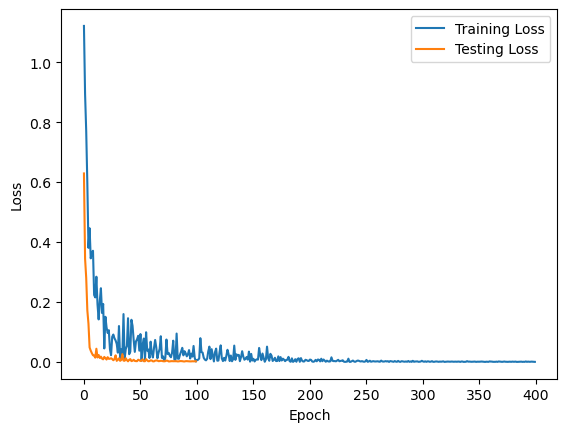

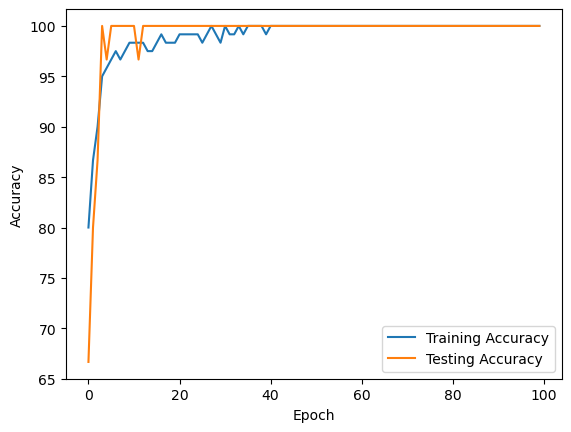

In [12]:
# Plot the training and testing losses
plt.plot(train_losses, label='Training Loss')
plt.plot(test_losses, label='Testing Loss')
plt.xlabel('Epoch')
plt.ylabel('Loss')
plt.legend()
plt.show()

# Plot the training and testing accuracies
plt.plot(train_accuracies, label='Training Accuracy')
plt.plot(test_accuracies, label='Testing Accuracy')
plt.xlabel('Epoch')
plt.ylabel('Accuracy')
plt.legend()
plt.show()

In [13]:
# Load the LabelEncoder object from a file
encoder = joblib.load('../data/processed/label_encoder.joblib')

# Reverse the label encoding
y_true = y_test.detach().numpy()
y_true_labels = encoder.inverse_transform(y_true)

# Set the network to evaluation mode
model.eval()

# Compute the predicted classes and probabilities for the testing data
y_pred = []
y_prob = []
with torch.no_grad():
    for inputs, targets in test_loader:
        outputs = model(inputs)
        probs = torch.softmax(outputs, dim=1)
        _, predicted = torch.max(outputs.data, 1)
        y_pred.extend(predicted.tolist())
        y_prob.extend(probs.tolist())

# Convert the testing data, predicted classes, and probabilities to numpy arrays
y_pred = np.array(y_pred)
y_prob = np.array(y_prob)

y_pred_labels = encoder.inverse_transform(y_pred)


In [14]:
# Compute the ROC curve and AUC for each class
fpr = dict()
tpr = dict()
roc_auc = dict()

for i, species in enumerate(encoder.classes_):
    y_true_binary = (y_true_labels == species)
    y_prob_binary = y_prob[:, i]
    fpr[species], tpr[species], _ = roc_curve(y_true_binary, y_prob_binary)
    roc_auc[species] = auc(fpr[species], tpr[species])


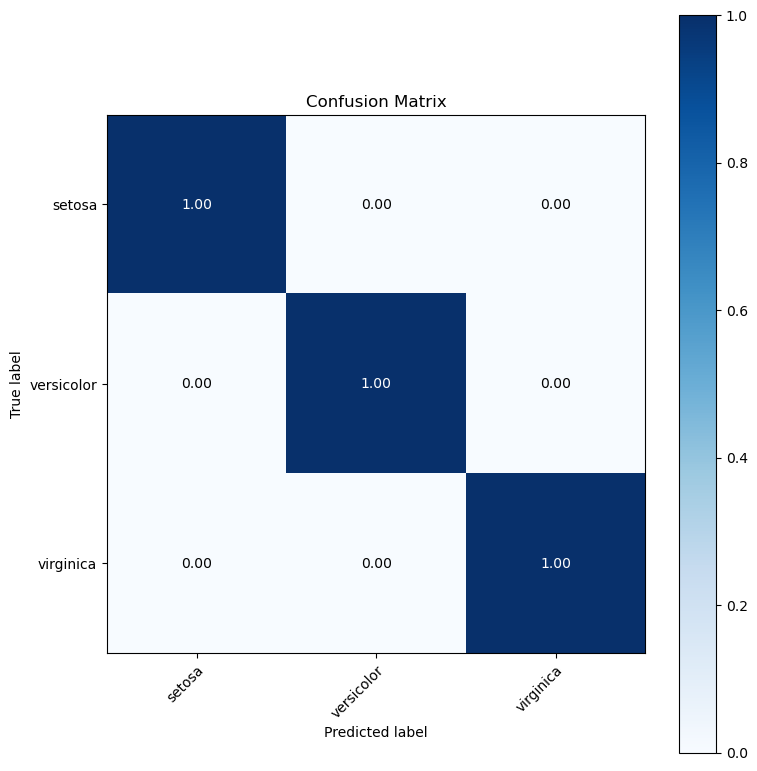

In [15]:
# Compute the confusion matrix
cm = confusion_matrix(y_true, y_pred)

# Define the class labels
classes = encoder.classes_

# Normalize the confusion matrix
cm_norm = cm.astype('float') / cm.sum(axis=1)[:, np.newaxis]

# Create a figure and axis object
fig, ax = plt.subplots(figsize=(8, 8))

# Plot the confusion matrix
im = ax.imshow(cm_norm, interpolation='nearest', cmap=plt.cm.Blues)

# Add colorbar
cbar = ax.figure.colorbar(im, ax=ax)

# Set axis labels and title
ax.set(xticks=np.arange(cm.shape[1]),
       yticks=np.arange(cm.shape[0]),
       xticklabels=classes, yticklabels=classes,
       xlabel='Predicted label', ylabel='True label',
       title='Confusion Matrix')

# Rotate the tick labels and set their alignment
plt.setp(ax.get_xticklabels(), rotation=45, ha="right",
         rotation_mode="anchor")

# Loop over data dimensions and create text annotations
thresh = cm_norm.max() / 2.
for i in range(cm_norm.shape[0]):
    for j in range(cm_norm.shape[1]):
        ax.text(j, i, format(cm_norm[i, j], '.2f'),
                ha="center", va="center",
                color="white" if cm_norm[i, j] > thresh else "black")

# Show the plot
plt.tight_layout()
plt.show()

In [16]:
# Compute the F1 score, precision, recall, and accuracy for each class
f1 = dict()
precision = dict()
recall = dict()
accuracy = dict()
for i, species in enumerate(encoder.classes_):
    y_true_binary = (y_true_labels == species)
    y_pred_binary = (y_pred_labels == species)
    f1[species] = f1_score(y_true_binary, y_pred_binary, zero_division=1)
    precision[species] = precision_score(y_true_binary, y_pred_binary, zero_division=1)
    recall[species] = recall_score(y_true_binary, y_pred_binary, zero_division=1)
    accuracy[species] = accuracy_score(y_true_binary, y_pred_binary)

# Print the F1 score, precision, recall, and accuracy for each class
for species in encoder.classes_:
    print(f'{species}:')
    print(f'F1 Score: {f1[species]:.2f}')
    print(f'Precision: {precision[species]:.2f}')
    print(f'Recall: {recall[species]:.2f}')
    print(f'Accuracy: {accuracy[species]:.2f}')
    print()

setosa:
F1 Score: 1.00
Precision: 1.00
Recall: 1.00
Accuracy: 1.00

versicolor:
F1 Score: 1.00
Precision: 1.00
Recall: 1.00
Accuracy: 1.00

virginica:
F1 Score: 1.00
Precision: 1.00
Recall: 1.00
Accuracy: 1.00



In [17]:
# Compute the micro-averaged F1 score, precision, recall, and accuracy
f1_micro = f1_score(y_true, y_pred, average='micro')
precision_micro = precision_score(y_true, y_pred, average='micro')
recall_micro = recall_score(y_true, y_pred, average='micro')
accuracy_micro = accuracy_score(y_true, y_pred)

# Compute the macro-averaged F1 score, precision, recall, and accuracy
f1_macro = f1_score(y_true, y_pred, average='macro')
precision_macro = precision_score(y_true, y_pred, average='macro')
recall_macro = recall_score(y_true, y_pred, average='macro')
accuracy_macro = accuracy_score(y_true, y_pred)

# Print the micro-averaged and macro-averaged F1 score, precision, recall, and accuracy
print('Micro-averaged:')
print(f'F1 Score: {f1_micro:.2f}')
print(f'Precision: {precision_micro:.2f}')
print(f'Recall: {recall_micro:.2f}')
print(f'Accuracy: {accuracy_micro:.2f}')
print()

print('Macro-averaged:')
print(f'F1 Score: {f1_macro:.2f}')
print(f'Precision: {precision_macro:.2f}')
print(f'Recall: {recall_macro:.2f}')
print(f'Accuracy: {accuracy_macro:.2f}')
print()

Micro-averaged:
F1 Score: 1.00
Precision: 1.00
Recall: 1.00
Accuracy: 1.00

Macro-averaged:
F1 Score: 1.00
Precision: 1.00
Recall: 1.00
Accuracy: 1.00



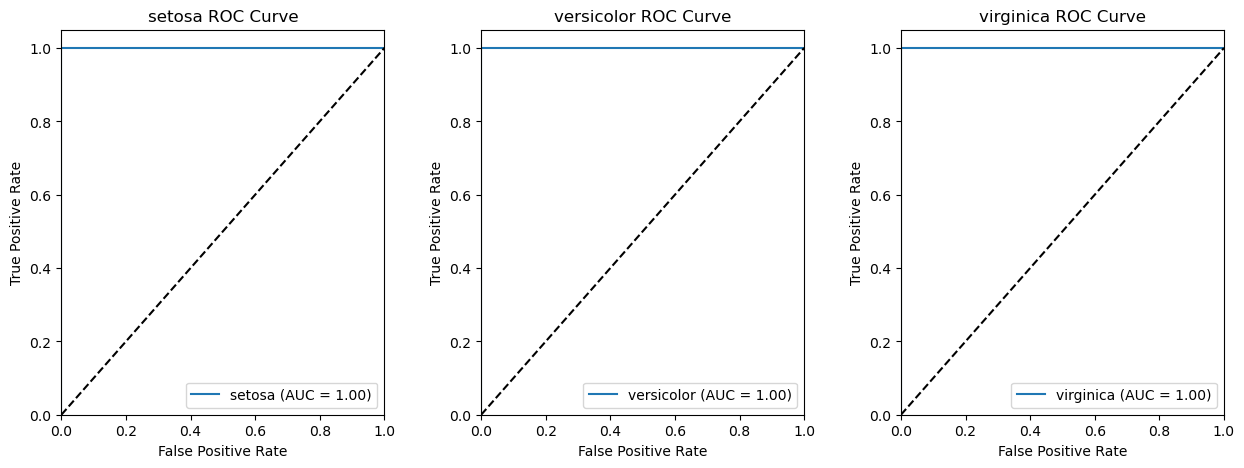

In [18]:
# Create a 1x3 grid of subplots
fig, axs = plt.subplots(1, 3, figsize=(15, 5))

# Loop over each class and plot the ROC curve and AUC in a separate subplot
for i, species in enumerate(encoder.classes_):
    ax = axs[i]
    ax.plot(fpr[species], tpr[species], label=f'{species} (AUC = {roc_auc[species]:.2f})')
    ax.plot([0, 1], [0, 1], 'k--')
    ax.set_xlim([0.0, 1.0])
    ax.set_ylim([0.0, 1.05])
    ax.set_xlabel('False Positive Rate')
    ax.set_ylabel('True Positive Rate')
    ax.set_title(f'{species} ROC Curve')
    ax.legend(loc='lower right')

# Adjust the spacing between subplots and show the plot
plt.subplots_adjust(wspace=0.3)
plt.show()

### Cross-validation

In [19]:
from sklearn.model_selection import KFold

# Determine the input size from the input data
input_size = X.shape[1]

# Determine the number of output classes from the target labels
output_size = len(torch.unique(y_train))

# Set the number of hidden units in each hidden layer
hidden_sizes = [100, 50]

# Set the number of folds for cross-validation
num_folds = 5

# Create a KFold object for cross-validation
kf = KFold(n_splits=num_folds, shuffle=True)

# Create lists to store losses and accuracies for each fold
train_losses = []
test_losses = []
train_accuracies = []
test_accuracies = []

# Perform k-fold cross-validation
for fold, (train_indices, test_indices) in enumerate(kf.split(X)):
    print(f"Fold {fold+1}/{num_folds}")
    
    # Split the data into training and testing sets for this fold
    X_train, y_train = X[train_indices], y[train_indices]
    X_test, y_test = X[test_indices], y[test_indices]

    # Convert arrays to PyTorch tensors
    X_train = torch.FloatTensor(X_train)
    X_test = torch.FloatTensor(X_test)
    y_train = torch.LongTensor(y_train)
    y_test = torch.LongTensor(y_test)
    
    # Create DataLoader objects for the training and testing data
    train_dataset = TensorDataset(X_train, y_train)
    train_loader = DataLoader(train_dataset, batch_size=32, shuffle=True)
    test_dataset = TensorDataset(X_test, y_test)
    test_loader = DataLoader(test_dataset, batch_size=32, shuffle=False)
    
    # Create an instance of the network, loss function and optimizer
    model = Net(input_size, hidden_sizes, output_size)
    criterion = nn.CrossEntropyLoss()
    optimizer = torch.optim.Adam(model.parameters(), lr=0.01)
    
    # Set the number of epochs
    num_epochs = 100
    
    # Train the network
    for epoch in range(num_epochs):
        # Set the network to training mode
        model.train()

        # Iterate over the training data in batches
        for i, (inputs, targets) in enumerate(train_loader):
            # Zero the gradients
            optimizer.zero_grad()

            # Forward pass
            outputs = model(inputs)
            loss = criterion(outputs, targets)

            # Backward pass and optimization
            loss.backward()
            optimizer.step()

            # Store the training loss
            train_losses.append(loss.item())

        # Set the network to evaluation mode
        model.eval()

        # Compute the loss and accuracy on the testing data
        test_loss = 0
        correct = 0
        total = 0

        with torch.no_grad():
            for inputs, targets in test_loader:
                outputs = model(inputs)
                loss = criterion(outputs, targets)
                test_loss += loss.item() * inputs.size(0)
                _, predicted = torch.max(outputs.data, 1)
                total += targets.size(0)
                correct += (predicted == targets).sum().item()

        test_loss /= len(test_loader.dataset)
        test_losses.append(test_loss)
        accuracy = 100 * correct / total
        test_accuracies.append(accuracy)

        # Compute the accuracy on the training data
        correct = 0
        total = 0
        with torch.no_grad():
            for inputs, targets in train_loader:
                outputs = model(inputs)
                _, predicted = torch.max(outputs.data, 1)
                total += targets.size(0)
                correct += (predicted == targets).sum().item()
        accuracy = 100 * correct / total
        train_accuracies.append(accuracy)

        # Print the loss and accuracy for this epoch
        print(f"Fold {fold+1}/{num_folds}, Epoch {epoch+1}/{num_epochs}, Loss: {loss.item():.4f}, Accuracy: {accuracy:.2f}%")
    
    # Print the average loss and accuracy for this fold
    train_loss = sum(train_losses) / len(train_losses)
    test_loss = sum(test_losses) / len(test_losses)
    train_accuracy = sum(train_accuracies) / len(train_accuracies)
    test_accuracy = sum(test_accuracies) / len(test_accuracies)
    print(f"Fold {fold+1}/{num_folds}, Average Train Loss: {train_loss:.4f}, Average Test Loss: {test_loss:.4f}, Average Train Accuracy: {train_accuracy:.2f}%, Average Test Accuracy: {test_accuracy:.2f}%")
    
    # Clear the lists for the next fold
    train_losses.clear()
    test_losses.clear()
    train_accuracies.clear()
    test_accuracies.clear()

Fold 1/5
Fold 1/5, Epoch 1/100, Loss: 0.3537, Accuracy: 80.00%
Fold 1/5, Epoch 2/100, Loss: 0.1518, Accuracy: 89.17%
Fold 1/5, Epoch 3/100, Loss: 0.1196, Accuracy: 92.50%
Fold 1/5, Epoch 4/100, Loss: 0.0693, Accuracy: 97.50%
Fold 1/5, Epoch 5/100, Loss: 0.0463, Accuracy: 98.33%
Fold 1/5, Epoch 6/100, Loss: 0.0617, Accuracy: 97.50%
Fold 1/5, Epoch 7/100, Loss: 0.0476, Accuracy: 97.50%
Fold 1/5, Epoch 8/100, Loss: 0.0668, Accuracy: 99.17%
Fold 1/5, Epoch 9/100, Loss: 0.0530, Accuracy: 98.33%
Fold 1/5, Epoch 10/100, Loss: 0.0591, Accuracy: 99.17%
Fold 1/5, Epoch 11/100, Loss: 0.0339, Accuracy: 97.50%
Fold 1/5, Epoch 12/100, Loss: 0.0821, Accuracy: 99.17%
Fold 1/5, Epoch 13/100, Loss: 0.0720, Accuracy: 98.33%
Fold 1/5, Epoch 14/100, Loss: 0.0941, Accuracy: 99.17%
Fold 1/5, Epoch 15/100, Loss: 0.0409, Accuracy: 98.33%
Fold 1/5, Epoch 16/100, Loss: 0.0714, Accuracy: 99.17%
Fold 1/5, Epoch 17/100, Loss: 0.0568, Accuracy: 98.33%
Fold 1/5, Epoch 18/100, Loss: 0.0818, Accuracy: 99.17%
Fold 1/5, 

### Hyperparameter tuning and cross-validation

In [21]:
from sklearn.model_selection import ParameterGrid

# Define a grid of hyperparameters
param_grid = {
    'lr': [0.001, 0.01],
    'batch_size': [16, 32],
}

best_loss = np.inf
best_params = {'lr': None, 'batch_size': None}

# Create a grid of parameters
param_list = list(ParameterGrid(param_grid))

# Perform hyperparameter tuning
for params in param_list:
    print(f"Parameters: {params}")
    
    for fold, (train_indices, test_indices) in enumerate(kf.split(X)):
        print(f"Fold {fold+1}/{num_folds}")

        # Split the data into training and testing sets for this fold
        X_train, y_train = X[train_indices], y[train_indices]
        X_test, y_test = X[test_indices], y[test_indices]

        # Convert arrays to PyTorch tensors
        X_train = torch.FloatTensor(X_train)
        X_test = torch.FloatTensor(X_test)
        y_train = torch.LongTensor(y_train)
        y_test = torch.LongTensor(y_test)

        # Create DataLoader objects for the training and testing data
        train_dataset = TensorDataset(X_train, y_train)
        train_loader = DataLoader(train_dataset, batch_size=params['batch_size'], shuffle=True)
        test_dataset = TensorDataset(X_test, y_test)
        test_loader = DataLoader(test_dataset, batch_size=params['batch_size'], shuffle=False)

        # Create an instance of the network, loss function and optimizer
        model = Net(input_size, hidden_sizes, output_size)
        criterion = nn.CrossEntropyLoss()
        optimizer = torch.optim.Adam(model.parameters(), lr=params['lr'])

        # Set the number of epochs
        num_epochs = 100

        # Train the network
        for epoch in range(num_epochs):
            # Set the network to training mode
            model.train()

            # Iterate over the training data in batches
            for i, (inputs, targets) in enumerate(train_loader):
                # Zero the gradients
                optimizer.zero_grad()

                # Forward pass
                outputs = model(inputs)
                loss = criterion(outputs, targets)

                # Backward pass and optimization
                loss.backward()
                optimizer.step()

                # Store the training loss
                train_losses.append(loss.item())

            # Set the network to evaluation mode
            model.eval()

            # Compute the loss and accuracy on the testing data
            test_loss = 0
            correct = 0
            total = 0

            with torch.no_grad():
                for inputs, targets in test_loader:
                    outputs = model(inputs)
                    loss = criterion(outputs, targets)
                    test_loss += loss.item() * inputs.size(0)
                    _, predicted = torch.max(outputs.data, 1)
                    total += targets.size(0)
                    correct += (predicted == targets).sum().item()

            test_loss /= len(test_loader.dataset)
            test_losses.append(test_loss)
            accuracy = 100 * correct / total
            test_accuracies.append(accuracy)

            # Compute the accuracy on the training data
            correct = 0
            total = 0
            with torch.no_grad():
                for inputs, targets in train_loader:
                    outputs = model(inputs)
                    _, predicted = torch.max(outputs.data, 1)
                    total += targets.size(0)
                    correct += (predicted == targets).sum().item()
            accuracy = 100 * correct / total
            train_accuracies.append(accuracy)

            # Print the loss and accuracy for this epoch
            print(f"Fold {fold+1}/{num_folds}, Epoch {epoch+1}/{num_epochs}, Loss: {loss.item():.4f}, Accuracy: {accuracy:.2f}%")
        
        # Print the average loss and accuracy for this fold
        train_loss = sum(train_losses) / len(train_losses)
        test_loss = sum(test_losses) / len(test_losses)
        train_accuracy = sum(train_accuracies) / len(train_accuracies)
        test_accuracy = sum(test_accuracies) / len(test_accuracies)
        print(f"Fold {fold+1}/{num_folds}, Average Train Loss: {train_loss:.4f}, Average Test Loss: {test_loss:.4f}, Average Train Accuracy: {train_accuracy:.2f}%, Average Test Accuracy: {test_accuracy:.2f}%")
        
        # Return average validation loss over all folds
        if test_loss < best_loss:
            best_loss = test_loss
            best_params['batch_size'] = params['batch_size']
            best_params['lr'] = params['lr']

        # Clear the lists for the next fold
        train_losses.clear()
        test_losses.clear()
        train_accuracies.clear()
        test_accuracies.clear()

print(f"Best parameters: Batch Size = {best_params['batch_size']}, Learning Rate = {best_params['lr']}")

Parameters: {'batch_size': 16, 'lr': 0.001}
Fold 1/5
Fold 1/5, Epoch 1/100, Loss: 0.8745, Accuracy: 69.17%
Fold 1/5, Epoch 2/100, Loss: 0.7434, Accuracy: 77.50%
Fold 1/5, Epoch 3/100, Loss: 0.6260, Accuracy: 80.83%
Fold 1/5, Epoch 4/100, Loss: 0.5286, Accuracy: 84.17%
Fold 1/5, Epoch 5/100, Loss: 0.4487, Accuracy: 86.67%
Fold 1/5, Epoch 6/100, Loss: 0.3792, Accuracy: 87.50%
Fold 1/5, Epoch 7/100, Loss: 0.3243, Accuracy: 88.33%
Fold 1/5, Epoch 8/100, Loss: 0.2819, Accuracy: 90.00%
Fold 1/5, Epoch 9/100, Loss: 0.2520, Accuracy: 90.83%
Fold 1/5, Epoch 10/100, Loss: 0.2168, Accuracy: 90.83%
Fold 1/5, Epoch 11/100, Loss: 0.1959, Accuracy: 94.17%
Fold 1/5, Epoch 12/100, Loss: 0.1794, Accuracy: 95.00%
Fold 1/5, Epoch 13/100, Loss: 0.1645, Accuracy: 95.00%
Fold 1/5, Epoch 14/100, Loss: 0.1588, Accuracy: 94.17%
Fold 1/5, Epoch 15/100, Loss: 0.1557, Accuracy: 94.17%
Fold 1/5, Epoch 16/100, Loss: 0.1355, Accuracy: 96.67%
Fold 1/5, Epoch 17/100, Loss: 0.1209, Accuracy: 96.67%
Fold 1/5, Epoch 18/10

### Final model training

In [30]:
# Split the dataset into training set and test set
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=0)

# Convert arrays to PyTorch tensors
X_train = torch.FloatTensor(X_train)
X_test = torch.FloatTensor(X_test)
y_train = torch.LongTensor(y_train)
y_test = torch.LongTensor(y_test)

# Determine the input size from the input data
input_size = X_train.shape[1]

# Determine the number of output classes from the target labels
output_size = len(torch.unique(y_train))

# Set the number of hidden units in each hidden layer
hidden_sizes = [100, 50]

# Set the number of epochs
num_epochs = 100

# Set hyperparameters from hyperparameter tuning
batch_size = best_params['batch_size'] # 16
learning_rate = best_params['lr'] # 0.01

# Create DataLoader objects for the training and testing data
train_dataset = TensorDataset(X_train, y_train)
train_loader = DataLoader(train_dataset, batch_size=batch_size, shuffle=True)
test_dataset = TensorDataset(X_test, y_test)
test_loader = DataLoader(test_dataset, batch_size=batch_size, shuffle=False)

# Create an instance of the network, loss function and optimizer
model = Net(input_size, hidden_sizes, output_size)
criterion = nn.CrossEntropyLoss()
optimizer = torch.optim.Adam(model.parameters(), lr=learning_rate)

In [31]:
# Create lists to store losses and accuracies
train_losses = []
test_losses = []
train_accuracies = []
test_accuracies = []

# Train the network
for epoch in range(num_epochs):
    # Set the network to training mode
    model.train()
    
    # Iterate over the training data in batches
    for i, (inputs, targets) in enumerate(train_loader):
        # Zero the gradients
        optimizer.zero_grad()
        
        # Forward pass
        outputs = model(inputs)
        loss = criterion(outputs, targets)
        
        # Backward pass and optimization
        loss.backward()
        optimizer.step()
        
        # Store the training loss
        train_losses.append(loss.item())

    # Set the network to evaluation mode
    model.eval()
    
    # Compute the loss and accuracy on the testing data
    test_loss = 0
    correct = 0
    total = 0
    
    with torch.no_grad():
        for inputs, targets in test_loader:
            outputs = model(inputs)
            loss = criterion(outputs, targets)
            test_loss += loss.item() * inputs.size(0)
            _, predicted = torch.max(outputs.data, 1)
            total += targets.size(0)
            correct += (predicted == targets).sum().item()

    test_loss /= len(test_loader.dataset)
    test_losses.append(test_loss)
    accuracy = 100 * correct / total
    test_accuracies.append(accuracy)
    
    # Compute the accuracy on the training data
    correct = 0
    total = 0
    with torch.no_grad():
        for inputs, targets in train_loader:
            outputs = model(inputs)
            _, predicted = torch.max(outputs.data, 1)
            total += targets.size(0)
            correct += (predicted == targets).sum().item()
    accuracy = 100 * correct / total
    train_accuracies.append(accuracy)
    
    # Print the loss and accuracy for this epoch
    print(f"Epoch {epoch+1}/{num_epochs}, Loss: {loss.item():.4f}, Accuracy: {accuracy:.2f}%")

Epoch 1/100, Loss: 0.9226, Accuracy: 77.50%
Epoch 2/100, Loss: 0.7921, Accuracy: 83.33%
Epoch 3/100, Loss: 0.6630, Accuracy: 80.00%
Epoch 4/100, Loss: 0.5466, Accuracy: 82.50%
Epoch 5/100, Loss: 0.4535, Accuracy: 84.17%
Epoch 6/100, Loss: 0.3823, Accuracy: 87.50%
Epoch 7/100, Loss: 0.3281, Accuracy: 88.33%
Epoch 8/100, Loss: 0.2808, Accuracy: 90.83%
Epoch 9/100, Loss: 0.2437, Accuracy: 92.50%
Epoch 10/100, Loss: 0.2174, Accuracy: 93.33%
Epoch 11/100, Loss: 0.1960, Accuracy: 94.17%
Epoch 12/100, Loss: 0.1682, Accuracy: 95.83%
Epoch 13/100, Loss: 0.1451, Accuracy: 95.83%
Epoch 14/100, Loss: 0.1299, Accuracy: 96.67%
Epoch 15/100, Loss: 0.1156, Accuracy: 96.67%
Epoch 16/100, Loss: 0.1010, Accuracy: 96.67%
Epoch 17/100, Loss: 0.0899, Accuracy: 95.83%
Epoch 18/100, Loss: 0.0815, Accuracy: 97.50%
Epoch 19/100, Loss: 0.0731, Accuracy: 97.50%
Epoch 20/100, Loss: 0.0656, Accuracy: 95.83%
Epoch 21/100, Loss: 0.0596, Accuracy: 95.83%
Epoch 22/100, Loss: 0.0565, Accuracy: 97.50%
Epoch 23/100, Loss:

In [32]:
# Save the model
torch.save(model, '../models/model.pth')